In [16]:
import os
import selectivesearch
import pandas as pd

from IPython.display import Image as DisplayImage, display
from torch_snippets import *
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import batched_nms
from torchvision.utils import make_grid

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# Let's get our directory straight
current_dir = os.getcwd()
data_path   = os.path.join(current_dir, 'data')
train_data  = os.path.join(data_path,'training_images')
test_data   = os.path.join(data_path, 'testing_images')
df_cars     = pd.read_csv(os.path.join(data_path,'train_solution_bounding_boxes (1).csv'))

In [18]:
df_cars

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


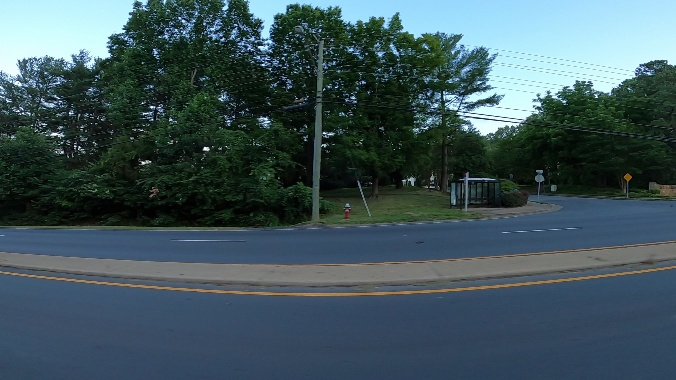

In [19]:
# Let's manually display an image here
img_manual_display = os.path.join(train_data, os.listdir(train_data)[17])
display(DisplayImage(filename = img_manual_display))

### Since there is no easy way of indexing images for selection I am aware of, I will create a class to have all the different paths as well as ensuring we are converting images from BGR to RGB 

In [20]:
class OpenImages(Dataset):
    def __init__(self, df, image_dir = train_data, transform = None):
        self.root = train_data
        self.df = df 
        self.transfrom = transform
        self.unique_images = df_cars['image'].unique()
        self.image_paths = {img_id: f'{self.root}/{img_id}' for img_id in self.unique_images}


    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, idx):
        img_id = self.unique_images[idx]
        image_path = self.image_paths[img_id]

        # Let's make sure the image is RGB 
        image = cv2.imread(image_path,1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        df_filtered = self.df[self.df['image'] == img_id]
        boxes = df_filtered[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.int32)
                                                                            
        return image, boxes, img_id

Now, we can define some a couple of functions, one to limit the aspect ratio of areas and another one to leverage the selectivesearch package and method to identify regions where there is a substantial change in pixel coloration within each of our images.

In [21]:
def filter_candidates_by_aspect_ratio(candidates, aspect_ratio_range=(0.3, 3.0)):
    filtered_candidates = []
    for x, y, w, h in candidates:
        aspect_ratio = w / float(h) if h > 0 else 0
        if aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
            filtered_candidates.append([x, y, w, h])
    return filtered_candidates


def selective_search_on_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _, regions = selectivesearch.selective_search(image_rgb, scale=500, min_size=10)
    return regions

In [22]:
# We can adjust the number of images displayed by adjusting the batch_size in DataLoader
def imgshow(img, text=None):
    npimg = img.numpy()
    plt.figure(figsize=(10,6))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    if text is not None:
        plt.text(75,8, text,style= 'italic', frontweight='bold',\
                bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad':10
                        })
    plt.show()

c:\Users\18126\miniconda3\envs\Torchcv\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


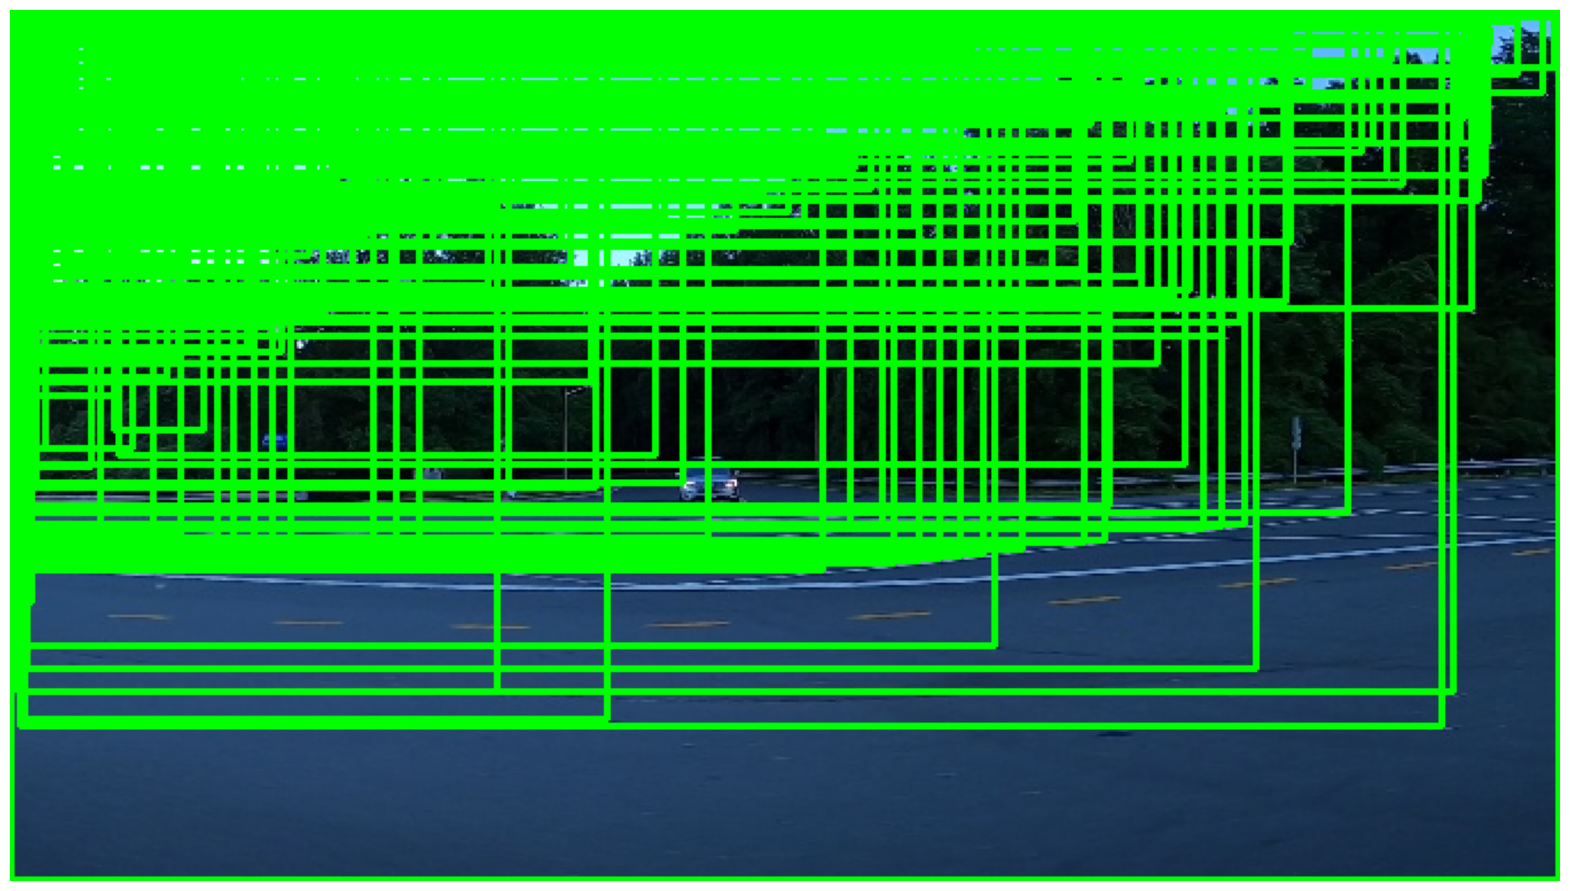

In [23]:
# Example usage
image_path = os.path.join(train_data, os.listdir(train_data)[0]) # This is how we can the image selection
regions = selective_search_on_image(image_path)

# Let's convert regions to a format suitable for filtering 
candidates = [r['rect'] for r in regions]

# Filter the regions based on the aspect ratio from our function
aspect_ratio_filtered_candidates = filter_candidates_by_aspect_ratio(candidates=candidates)

# Display the image with region proposals
image = read(image_path, 1)
show(image, bbs=aspect_ratio_filtered_candidates)

The previous code does not look very pretty.But trust me, it can be worse without our filter by aspect ratio function. Luckily, we have informationas to where each the recctangle should be drawn for each of image in our df dataframe. (Figuring this out took me about 4 hours) Now I know that I shouldn't try building everything from scratch hehe.

In [24]:
def draw_boxes(image,boxes):        
    for box in boxes: 
        xmin,ymin,xmax,ymax = box
        xmin,ymin,xmax,ymax = map(int,[xmin,ymin,xmax,ymax])
        cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,255,0),2) 
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

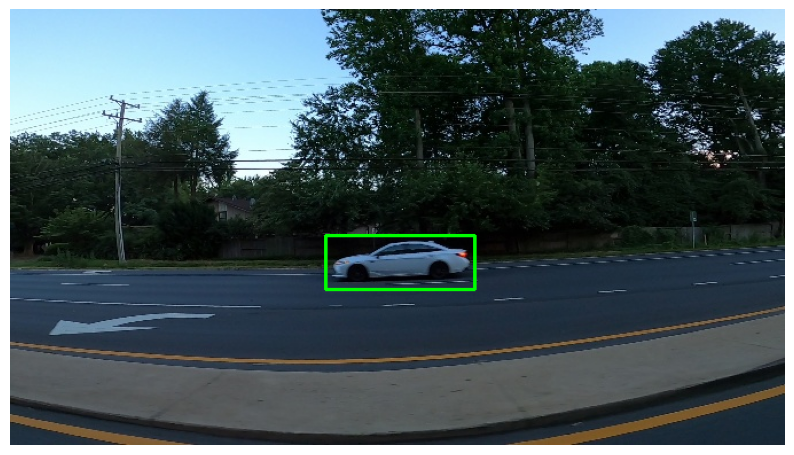

In [25]:
dataset = OpenImages(df_cars, train_data)

image_test1, boxes_test1, img_id = dataset[19] # We can change this value to get the different images
draw_boxes(image= image_test1,boxes=boxes_test1)

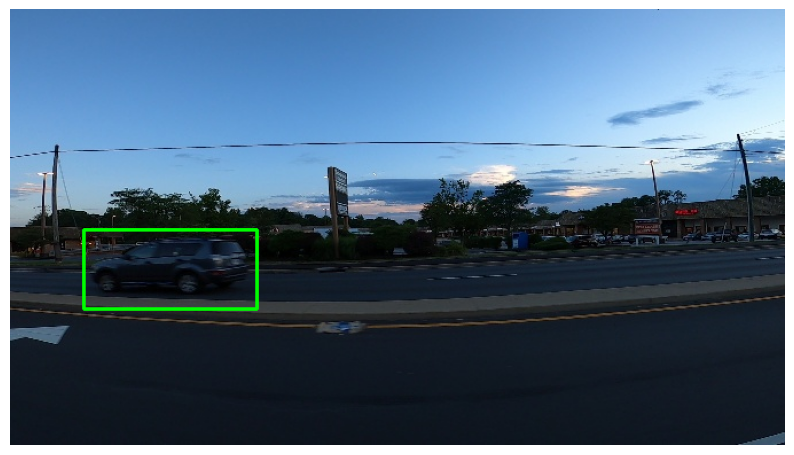

In [26]:
# Let's see another one with slightly different context
image_test1, boxes_test1, img_id = dataset[99] 
draw_boxes(image= image_test1,boxes=boxes_test1)

### Let's Build a Model That we can test against the test dataset

In [27]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
from pathlib import Path

class VehicleDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.path / row.image
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bbox_coords = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        if self.transform:
            image = self.transform(image)

        return {'image': torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.}, {'coords': torch.tensor(bbox_coords, dtype=torch.float32)}

# Assuming train_path is a Path object and train is your DataFrame
train_dataset = VehicleDataset(df=df_cars, path=train_data, transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((380, 676)),
    transforms.ToTensor()
]))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [28]:
import torch.nn as nn
import torch.nn.functional as F

class VehicleDetectionModel(nn.Module):
    def __init__(self):
        super(VehicleDetectionModel, self).__init__()
        self.features = nn.Sequential()
        n_filters = 8
        for i in range(10):
            self.features.add_module(f"conv2d_{i}", nn.Conv2d(in_channels=n_filters, out_channels=n_filters*2, kernel_size=3, padding='same'))
            self.features.add_module(f"batchnorm_{i}", nn.BatchNorm2d(n_filters*2))
            self.features.add_module(f"relu_{i}", nn.ReLU())
            self.features.add_module(f"maxpool_{i}", nn.MaxPool2d(kernel_size=2))
            n_filters *= 2
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters * (380 // 2**10) * (676 // 2**10), 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VehicleDetectionModel()


c:\Users\18126\miniconda3\envs\Torchcv\lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [29]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data['image'].to(device), data['coords'].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Loss: {running_loss / len(dataloader)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)




TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
# Training loop
for epoch in range(9):
    train_one_epoch(model, train_loader, optimizer, criterion, device)
    # Implement your testing/displaying logic here similar to the test_model function

## Conclusion
In this notebook, we were able to not only 